In [1]:
import train_utils

In [2]:
import metrics_utils
import preds_utils

In [3]:
import os
# DECLARE HOW MANY GPUS YOU WISH TO USE. 
# KAGGLE ONLY HAS 1, BUT OFFLINE, YOU CAN USE MORE
os.environ["CUDA_VISIBLE_DEVICES"]="0" #0,1,2,3 for four gpu

DATA_PATH = 'data'

In [4]:
from config import Config

config = Config()

In [5]:
import matplotlib.pyplot as plt

In [6]:
import numpy as np 
import pandas as pd 
from tqdm import tqdm
import gc
from transformers import AutoTokenizer, AutoModelForTokenClassification
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.metrics import accuracy_score

In [7]:
from data_utils import WritingEvalDataset

In [8]:
from ast import literal_eval
train_text_df = pd.read_csv(f'{DATA_PATH}/train_NER.csv')
# pandas saves lists as string, we must convert back
train_text_df = train_text_df.sample(frac=1).reset_index(drop=True)
train_text_df.entities = train_text_df.entities.apply(lambda x: literal_eval(x))

In [9]:
output_labels = ['O', 'B-Lead', 'I-Lead', 'B-Position', 'I-Position', 'B-Claim', 'I-Claim', 'B-Counterclaim', 'I-Counterclaim', 
          'B-Rebuttal', 'I-Rebuttal', 'B-Evidence', 'I-Evidence', 'B-Concluding Statement', 'I-Concluding Statement']

labels_to_ids = {v:k for k,v in enumerate(output_labels)}
ids_to_labels = {k:v for k,v in enumerate(output_labels)}

In [10]:
tokenizer = AutoTokenizer.from_pretrained(config.model, add_prefix_space=True)

In [29]:
tokenizer.save_pretrained('saved_model')

('saved_model/tokenizer_config.json',
 'saved_model/special_tokens_map.json',
 'saved_model/vocab.json',
 'saved_model/merges.txt',
 'saved_model/added_tokens.json',
 'saved_model/tokenizer.json')

In [11]:
model = AutoModelForTokenClassification.from_pretrained(config.model,
                                                        num_labels = 15).to(config.device)

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForTokenClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing LongformerForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForTokenClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN

In [12]:
gt_df = pd.read_csv(DATA_PATH + '/train.csv')

In [13]:
import sklearn
from sklearn.model_selection import train_test_split
train_val_df, test_df = train_test_split(train_text_df, test_size=0.1, random_state=42)

train_df, val_df = train_test_split(train_val_df, test_size=0.1, random_state=42)

train_ds = WritingEvalDataset(train_df, tokenizer)
val_ds =  WritingEvalDataset(val_df, tokenizer)
test_ds = WritingEvalDataset(test_df, tokenizer, False)

In [14]:
# TRAIN DATASET AND VALID DATASET
train_params = {'batch_size': config.train_batch_size,
                'shuffle': True,
                'num_workers': 16,
                'pin_memory':True
                }

test_params = {'batch_size': config.valid_batch_size,
                'shuffle': False,
                'num_workers': 16,
                'pin_memory':True
                }
train_data = DataLoader(train_ds, **train_params)
val_data = DataLoader(val_ds, **train_params)
test_data = DataLoader(test_ds, **test_params)

In [15]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=config.learning_rates[0])

In [16]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []

In [17]:
for epoch in range(config.epochs):
    
    print(f"Epoch: {epoch + 1}, Learning rate = {config.learning_rates[epoch]}")
    for g in optimizer.param_groups: 
        g['lr'] = config.learning_rates[epoch]
    lr = optimizer.param_groups[0]['lr']
    
    train_loss, train_acc = train_utils.train_one_epoch(model, train_data, optimizer)
    print(f"Training loss epoch: {train_loss}")
    print(f"Training accuracy epoch: {train_acc}")
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    val_loss, val_acc = train_utils.val_one_epoch(model, val_data)
    print(f"Val loss epoch: {val_loss}")
    print(f"Val accuracy epoch: {val_acc}")
    val_losses.append(val_loss)
    val_accs.append(val_acc)
        
    torch.cuda.empty_cache()
    gc.collect()


  0%|          | 0/12630 [00:00<?, ?it/s]

Epoch: 1, Learning rate = 2.5e-05


100%|██████████| 12630/12630 [43:33<00:00,  4.83it/s]

Training loss epoch: 0.8077590947969273
Training accuracy epoch: 0.7307607733101935



  0%|          | 0/12630 [00:00<?, ?it/s]

Val loss epoch: 0.7118851880932975
Val accuracy epoch: 0.7554350496362013
Epoch: 2, Learning rate = 2.5e-05


100%|██████████| 12630/12630 [43:25<00:00,  4.85it/s]

Training loss epoch: 0.6532025307891794
Training accuracy epoch: 0.7764886584565338



  0%|          | 0/12630 [00:00<?, ?it/s]

Val loss epoch: 0.6994342436016328
Val accuracy epoch: 0.762390674277153
Epoch: 3, Learning rate = 2.5e-05


100%|██████████| 12630/12630 [43:29<00:00,  4.84it/s]

Training loss epoch: 0.5677751688659044
Training accuracy epoch: 0.8027026829379554


Val loss epoch: 0.7062647365421014
Val accuracy epoch: 0.7592279283776082


  0%|          | 0/12630 [00:00<?, ?it/s]

Epoch: 4, Learning rate = 2.5e-05


100%|██████████| 12630/12630 [43:17<00:00,  4.86it/s]

Training loss epoch: 0.4979466608109768
Training accuracy epoch: 0.8261052013621691



  0%|          | 0/12630 [00:00<?, ?it/s]

Val loss epoch: 0.7537203727520875
Val accuracy epoch: 0.7598001920089401
Epoch: 5, Learning rate = 2.5e-06


100%|██████████| 12630/12630 [43:17<00:00,  4.86it/s]

Training loss epoch: 0.3535463388391305
Training accuracy epoch: 0.8763154312501079


Val loss epoch: 0.7782030543010613
Val accuracy epoch: 0.7637804741938302


In [18]:
model.save_pretrained('./saved_model/longformer-02-11v3')

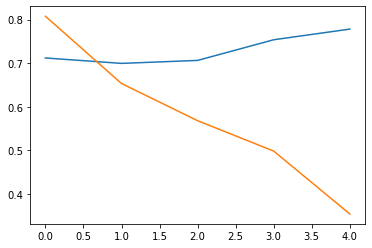

In [19]:
plt.plot(val_losses)
plt.plot(train_losses)

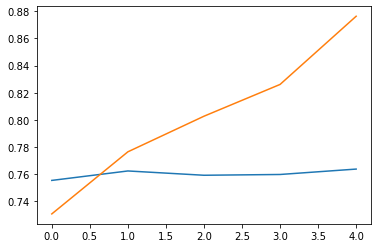

In [20]:
plt.plot(val_accs)
plt.plot(train_accs)

In [21]:
#Get ids in valid
VALID_IDS = test_df.id.unique()
valid = gt_df.loc[gt_df['id'].isin(VALID_IDS)]
valid = valid.sort_values('id')

all_preds = preds_utils.get_predictions(model, test_data)
preds_df = preds_utils.get_preds_df(test_df, all_preds)

preds_df = preds_df.sort_values('id')

# COMPUTE F1 SCORE
f1s = []
CLASSES = preds_df['class'].unique()
print()
for c in CLASSES:
    pred_df = preds_df.loc[preds_df['class']==c].copy()
    class_df = valid.loc[valid['discourse_type']==c].copy()
    f1 = metrics_utils.score_feedback_comp(pred_df, class_df)
    print(c,f1)
    f1s.append(f1)
print()
print('Overall',np.mean(f1s))
print()

100%|██████████| 1560/1560 [01:30<00:00, 17.29it/s]



Counterclaim 0.4769114307342922
Evidence 0.646049565769964
Concluding Statement 0.7708111937654977
Rebuttal 0.40948275862068967
Claim 0.4996105485701569
Position 0.6455997281685355
Lead 0.7792207792207793

Overall 0.6039551435499879



In [22]:
test_names, test_texts = [], []
for f in list(os.listdir('data/test')):
    test_names.append(f.replace('.txt', ''))
    test_texts.append(open('data/test/' + f, 'r').read())
test_texts = pd.DataFrame({'id': test_names, 'text': test_texts})
test_texts.head()

,id,text
0,D46BCB48440A,"When people ask for advice,they sometimes talk..."
1,D72CB1C11673,Making choices in life can be very difficult. ...
2,DF920E0A7337,Have you ever asked more than one person for h...
3,18409261F5C2,80% of Americans believe seeking multiple opin...
4,0FB0700DAF44,"During a group project, have you ever asked a ..."


In [23]:
test_texts_set = WritingEvalDataset(test_texts, tokenizer, False)
test_texts_loader = DataLoader(test_texts_set, **test_params)

In [26]:
all_test_preds = preds_utils.get_predictions(model, test_texts_loader)
test_df = preds_utils.get_preds_df(test_texts, all_test_preds, 7)

100%|██████████| 5/5 [00:00<00:00,  7.42it/s]


In [28]:
test_df.to_csv('submission.csv', index=False)